<h1> CV2 IMAGES ARE BGR NOT RGB </H1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!unzip -q "/content/drive/MyDrive/cv_project/zixGCRbr" 

In [ ]:
!unzip -q "/content/drive/MyDrive/cv_project/targets_test" -d "dataset/"

In [ ]:
!unzip -q "/content/drive/MyDrive/cv_project/dataset_invertito.zip" -d "dataset/"

In [ ]:
import pandas as pd
import numpy as np
import requests
import cv2
from PIL import Image
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import time
import pylab as pl
from IPython import display

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  

%matplotlib inline

In [ ]:
!pip install kornia
import kornia as K

     |████████████████████████████████| 474 kB 5.4 MB/s 


# create dataset


In [ ]:
#read csv with metadata
df = pd.read_csv('/content/drive/MyDrive/cv_project/metadata/all_data.csv')  

In [ ]:

for i in range(633801  , 2000000):#100k images
  row = df.iloc[i]  
  if "solo" not in row["tags"]:
    continue
  link = row["sample_url"]
  link = "http:"+link
  ext = link[-3:] 
  if ext == "gif":
    continue 
  response = requests.get(link, timeout=4)
  if response.status_code != 200:
    print("invalid request")
    continue
  img_data = response.content  
  print(i, ext)
  with open(str(0)+'.'+ext, 'wb') as handler:
      handler.write(img_data)
      image = cv2.imread(str(0)+'.'+ext)
      grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      laplacian = cv2.Laplacian(grayImage,cv2.CV_8U, ksize=3)
      #laplacian = cv2.bitwise_not(laplacian)      #bianco e nero 
      ret3 =  cv2.adaptiveThreshold(grayImage,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 15,2)
      #res = cv2.resize(img,(256,256), interpolation = cv2.INTER_AREA )
      ret3 = cv2.bitwise_not(ret3)      #bianco e nero per ret
      cv2.imwrite(r"local_dataset2/lap2/"+str(i)+".jpg",  cv2.resize(laplacian,(256,256), interpolation = cv2.INTER_AREA ))
      cv2.imwrite(r"local_dataset2/ret2/"+str(i)+".jpg",  cv2.resize(ret3,(256,256), interpolation = cv2.INTER_AREA ))
      cv2.imwrite(r"local_dataset2/target2/"+str(i)+".jpg",  cv2.resize(image,(256,256), interpolation = cv2.INTER_AREA ))


In [ ]:
path = "local_dataset2/target2/"
count = [f for f in listdir(path) if isfile(join(path, f))]
print(len(count))

18739


In [ ]:
!tar -zcvf /content/drive/MyDrive/cv_project/dat_compressed.tar2.gz local_dataset2

In [ ]:
!tar -xvzf /content/drive/MyDrive/cv_project/dat_compressed.tar.gz -C /content/dataset/

In [ ]:
!unzip -q "/content/drive/MyDrive/cv_project/dataset_invertito.zip" -d "dataset/"
!tar -xvzf /content/drive/MyDrive/cv_project/dat_compressed.tar.gz -C /content/dataset/
!mv   /content/dataset/local_dataset/ret2/* /content/dataset/dataset_invertito/ret2/
!mv   /content/dataset/local_dataset/target2/* /content/dataset/dataset_invertito/target2/
!tar -xvzf /content/drive/MyDrive/cv_project/dat_compressed.tar2.gz -C /content/dataset/
!mv   /content/dataset/local_dataset2/ret2/* /content/dataset/dataset_invertito/ret2/
!mv   /content/dataset/local_dataset2/target2/* /content/dataset/dataset_invertito/target2/
path = "/content/dataset/dataset_invertito/ret2/"
count = [f for f in listdir(path) if isfile(join(path, f))]
print(len(count))

In [ ]:
!tar -xvzf /content/drive/MyDrive/cv_project/dat_compressed2.tar.gz -C /content/dataset/


In [ ]:
!mv   /content/dataset/local_dataset/ret2/* /content/dataset/dataset_invertito/ret2/
!mv   /content/dataset/local_dataset/target2/* /content/dataset/dataset_invertito/target2/
path = "/content/dataset/dataset_invertito/ret2/"
count = [f for f in listdir(path) if isfile(join(path, f))]
print(len(count))

mv: cannot stat '/content/dataset/local_dataset/ret2/*': No such file or directory
mv: cannot stat '/content/dataset/local_dataset/target2/*': No such file or directory
17712


# architecture model

In [ ]:

class Tandem_network(torch.nn.Module):
  #the network will follow the U-Net architecture
  def __init__(self, first_tandem):
      super().__init__()
      in_ch = 4
      self.first_tandem = first_tandem
      if first_tandem:
        in_ch = 1        
      out_ch = 64
      #convolution
      self.conv1 = torch.nn.Conv2d(in_channels=in_ch, out_channels= out_ch, kernel_size = (5,5), stride = 2 , padding=2)
      self.bn1 = torch.nn.BatchNorm2d(out_ch)
      self.conv2 = torch.nn.Conv2d(in_channels=out_ch, out_channels= out_ch*2, kernel_size=(5,5), stride= 2 , padding=2)
      self.bn2 = torch.nn.BatchNorm2d(out_ch*2)
      self.conv3 = torch.nn.Conv2d(in_channels= out_ch*2, out_channels= out_ch*4, kernel_size=(5,5), stride= 2, padding=2)
      self.bn3 = torch.nn.BatchNorm2d(out_ch*4)
      self.conv4 = torch.nn.Conv2d(in_channels= out_ch*4, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn4 = torch.nn.BatchNorm2d(out_ch*8)
      self.conv5m = torch.nn.Conv2d(in_channels= out_ch * 8, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn5 = torch.nn.BatchNorm2d(out_ch*8)
      #de convolution
      self.conv4t = torch.nn.ConvTranspose2d(in_channels=out_ch*8, out_channels=out_ch*8, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn6 = torch.nn.BatchNorm2d(out_ch*8)
      self.conv3t = torch.nn.ConvTranspose2d(in_channels=out_ch*8, out_channels=out_ch*4, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn7 = torch.nn.BatchNorm2d(out_ch*4)
      self.conv2t = torch.nn.ConvTranspose2d(in_channels=out_ch*4, out_channels=out_ch*2, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn8 = torch.nn.BatchNorm2d(out_ch*2)
      self.conv1t = torch.nn.ConvTranspose2d(in_channels=out_ch*2, out_channels=out_ch, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn9 = torch.nn.BatchNorm2d(out_ch)
      self.conv0t = torch.nn.ConvTranspose2d(in_channels=out_ch, out_channels=3, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      #self.bn10 = torch.nn.BatchNorm2d(3)
      
      if self.first_tandem:
        self.conv_x = torch.nn.Conv2d(in_channels= 3, out_channels = 3, kernel_size=(8,8), stride= 8, padding=0)   
        self.bn_x = torch.nn.BatchNorm2d(3)   
        #self.fc = torch.nn.Linear(3072,3)
  
  def forward(self,x):
    #print("print shape inizio  ", x.shape)

    c1 = self.conv1(x)
    c1 = F.relu( self.bn1(c1) ) 
    c2 = self.conv2(c1)
    c2 = F.relu( self.bn2(c2) )
    c3 = self.conv3(c2)
    c3 = F.relu( self.bn3(c3) )
    c4 = self.conv4(c3)
    c4 = F.relu( self.bn4(c4) )
    c5m = self.conv5m(c4) 
    c5m = F.relu( self.bn5(c5m) )
    res4 =  self.bn6( self.conv4t(c5m) )
    #print("print shape first transpose ",res4.shape, " shape c4", c4.shape)
    res4 = F.relu( c4 + res4 )
    
    res3 = F.relu( self.bn7 ( self.conv3t(res4) )  + c3 )
    res2 = F.relu( self.bn8( self.conv2t(res3) ) + c2 )
    res1 = F.relu( self.bn9( self.conv1t(res2) ) + c1 )
    out = F.tanh(  self.conv0t(res1)  )
    #print("final shape of network ", out.shape) 
    
    if self.first_tandem:    
      conv_x = self.conv_x(out)   
      c_x = F.tanh( self.bn_x(conv_x) ) 
      #print(c_x.shape)
      """  
      out_first_tandem = c_x.flatten(start_dim=1)
      print(out_first_tandem.shape)
      out2 = torch.sigmoid( self.fc(out_first_tandem) )
      print(out2.shape)   
      """   
      out_up = torch.nn.Upsample(scale_factor=8, mode='nearest')(c_x) 
      #out_up = c_x.repeat(1,1024)
      #print(out_up.shape)
      #out_up_shapes = out_up.shape
      #out_up = out_up.view(out_up_shapes[0], 3, 32, 32)
      #out_up = out_up.view(out_up_shapes[0], 3, 256, 256)
      return out_up

    return out

In [ ]:
class Discriminator(torch.nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,5), stride=2, padding=2)
      self.bn1 = torch.nn.BatchNorm2d(64)
      self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5), stride=2, padding=2)
      self.bn2 = torch.nn.BatchNorm2d(128)
      self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5,5), stride=2, padding=2)
      self.bn3 = torch.nn.BatchNorm2d(256)
      self.conv4 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(5,5), stride=2, padding=2)
      self.bn4 = torch.nn.BatchNorm2d(512)
      self.drop = torch.nn.Dropout(p=0.2)
      self.fc = torch.nn.Linear(131072, 1)

  def forward(self, x):
    #print("shape discriminator :", x.shape)
    x = F.leaky_relu( self.bn1( self.conv1(x) ), 0.2)
    x =  F.leaky_relu( self.bn2( self.conv2(x) ), 0.2)
    x =  F.leaky_relu( self.bn3( self.conv3(x) ), 0.2)
    x =  F.leaky_relu( self.bn4( self.conv4 (x) ), 0.2)
    #print("shape end conv discriminator :", x.shape)
    x = x.flatten(start_dim=1)
    x = self.drop(x)
    out = self.fc(x)
    #out = F.sigmoid(out)
    return out

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

# Alternative model

In [ ]:
class ResNetXt_block(torch.nn.Module):
  def __init__(self, b_size):
      super().__init__()
      channels = b_size[1]
      self.s = b_size
      self.depthwise_conv = torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=(7,7), stride=1, padding=3)
      self.up_conv = torch.nn.Conv2d(in_channels=channels, out_channels=channels*4, kernel_size=(1,1), stride=1)
      self.down_conv = torch.nn.Conv2d(in_channels=channels*4, out_channels=channels, kernel_size=(1,1), stride=1)
      self.norm1 = torch.nn.LayerNorm([b_size[1], b_size[2], b_size[3]])

  def forward(self, x):
      #print(x.shape, self.s)
      c1 = self.depthwise_conv(x)
      c1 = self.norm1(c1)
      c2 = F.gelu( self.up_conv(c1) )
      c3 = self.down_conv(c2)
      out = c3 + x 
      return out

In [ ]:
save="Xt"
#if you wish to increase the capacity of the model add more resnetXt block
class TandemXt(torch.nn.Module):
  #the network will follow the U-Net architecture
  def __init__(self, first_tandem):
      super().__init__()
      in_ch = 4
      self.first_tandem = first_tandem
      if first_tandem:
        in_ch = 1        
      out_ch = 64
      #the order is first convolution that decreases the size
      #then a stage begins, a stage is done by many ResNetXt(1,N) and final layer norm
      #after convolution that decreases size a new stage begins 
      self.conv1 = torch.nn.Conv2d(in_channels=in_ch, out_channels= out_ch, kernel_size = (5,5), stride = 2 , padding=2)
      self.Xt1 = ResNetXt_block([0, out_ch, 128, 128])
      self.ln1 = torch.nn.LayerNorm([out_ch, 128, 128])
      self.conv2 = torch.nn.Conv2d(in_channels=out_ch, out_channels= out_ch*2, kernel_size=(5,5), stride= 2 , padding=2)
      self.Xt2 = ResNetXt_block([0, out_ch*2, 64, 64])
      self.ln2 = torch.nn.LayerNorm([out_ch*2, 64, 64])
      self.conv3 = torch.nn.Conv2d(in_channels= out_ch*2, out_channels= out_ch*4, kernel_size=(5,5), stride= 2, padding=2)
      self.Xt3 = ResNetXt_block([0, out_ch*4, 32, 32])
      self.ln3 = torch.nn.LayerNorm([out_ch*4, 32, 32])
      self.conv4 = torch.nn.Conv2d(in_channels= out_ch*4, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.Xt4 = ResNetXt_block([0, out_ch*8, 16, 16])
      self.ln4 = torch.nn.LayerNorm([out_ch*8, 16, 16])
      self.conv5m = torch.nn.Conv2d(in_channels= out_ch * 8, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.Xt5 = ResNetXt_block([0, out_ch*8, 8, 8])
      self.ln5 = torch.nn.LayerNorm([out_ch*8, 8, 8])
      #de convolution
      self.conv4t = torch.nn.ConvTranspose2d(in_channels=out_ch*8, out_channels=out_ch*8, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.Xt6 = ResNetXt_block([0, out_ch*8, 16, 16])
      self.ln6 = torch.nn.LayerNorm([out_ch*8, 16, 16])
      self.conv3t = torch.nn.ConvTranspose2d(in_channels=out_ch*8, out_channels=out_ch*4, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.Xt7 = ResNetXt_block([0, out_ch*4, 32, 32])
      self.ln7 = torch.nn.LayerNorm([out_ch*4, 32, 32])
      self.conv2t = torch.nn.ConvTranspose2d(in_channels=out_ch*4, out_channels=out_ch*2, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.Xt8 = ResNetXt_block([0, out_ch*2, 64, 64])
      self.ln8 = torch.nn.LayerNorm([out_ch*2, 64, 64])
      self.conv1t = torch.nn.ConvTranspose2d(in_channels=out_ch*2, out_channels=out_ch, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.Xt9 = ResNetXt_block([0, out_ch, 128, 128])
      self.ln9 = torch.nn.LayerNorm([out_ch, 128, 128])
      self.conv0t = torch.nn.ConvTranspose2d(in_channels=out_ch, out_channels=3, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.Xt10 = ResNetXt_block([0, 3, 256, 256])
      #self.bn10 = torch.nn.BatchNorm2d(3)
      
      if self.first_tandem:
        self.conv_x = torch.nn.Conv2d(in_channels= 3, out_channels = 3, kernel_size=(8,8), stride= 8, padding=0)   
        self.bn_x = torch.nn.BatchNorm2d(3)   
        #self.fc = torch.nn.Linear(3072,3)
  
  def forward(self,x):
    #print("print shape inizio  ", x.shape)

    c1 = self.conv1(x)
    c1 = self.Xt1(c1)
    c1 = self.ln1(c1)  
    c2 = self.conv2(c1)
    c2 = self.Xt2(c2)
    c2 = self.ln2(c2) 
    c3 = self.conv3(c2)
    c3 = self.Xt3(c3)
    c3 = self.ln3(c3) 
    c4 = self.conv4(c3)
    c4 = self.Xt4(c4)
    c4 = self.ln4(c4) 
    c5m = self.conv5m(c4) 
    c5m = self.Xt5(c5m)
    c5m = self.ln5(c5m) 
    res4 =  self.ln6( self.Xt6( self.conv4t(c5m) ) )
    #print("print shape first transpose ",res4.shape, " shape c4", c4.shape)
    res4 =  c4 + res4 
    
    res3 = self.ln7(self.Xt7 ( self.conv3t(res4) )  + c3 )
    res2 = self.ln8(self.Xt8( self.conv2t(res3) ) + c2 )
    res1 = self.ln9( self.Xt9( self.conv1t(res2) ) + c1 )
    out = F.tanh(  self.Xt10( self.conv0t(res1) ) )
    #print("final shape of network ", out.shape) 
    
    if self.first_tandem:    
      conv_x = self.conv_x(out)   
      c_x = F.tanh( self.bn_x(conv_x) ) 
      #print(c_x.shape)
      """  
      out_first_tandem = c_x.flatten(start_dim=1)
      print(out_first_tandem.shape)
      out2 = torch.sigmoid( self.fc(out_first_tandem) )
      print(out2.shape)   
      """   
      out_up = torch.nn.Upsample(scale_factor=8, mode='nearest')(c_x) 
      #out_up = c_x.repeat(1,1024)
      #print(out_up.shape)
      #out_up_shapes = out_up.shape
      #out_up = out_up.view(out_up_shapes[0], 3, 32, 32)
      #out_up = out_up.view(out_up_shapes[0], 3, 256, 256)
      return out_up

    return out

In [ ]:
save="alternative"
class Tandem_network(torch.nn.Module):
  #the network will follow the U-Net architecture
  def __init__(self, first_tandem):
      super().__init__()
      in_ch = 4
      self.first_tandem = first_tandem
      if first_tandem:
        in_ch = 1        
      out_ch = 64
      #convolution
      self.conv1 = torch.nn.Conv2d(in_channels=in_ch, out_channels= out_ch, kernel_size = (5,5), stride = 2 , padding=2)
      self.bn1 = torch.nn.BatchNorm2d(out_ch)
      self.conv2 = torch.nn.Conv2d(in_channels=out_ch, out_channels= out_ch*2, kernel_size=(5,5), stride= 2 , padding=2)
      self.bn2 = torch.nn.BatchNorm2d(out_ch*2)
      self.conv3 = torch.nn.Conv2d(in_channels= out_ch*2, out_channels= out_ch*4, kernel_size=(5,5), stride= 2, padding=2)
      self.bn3 = torch.nn.BatchNorm2d(out_ch*4)
      self.conv4 = torch.nn.Conv2d(in_channels= out_ch*4, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn4 = torch.nn.BatchNorm2d(out_ch*8)
      self.conv5m = torch.nn.Conv2d(in_channels= out_ch * 8, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn5 = torch.nn.BatchNorm2d(out_ch*8)
      #de convolution
      self.up = torch.nn.Upsample(scale_factor=2)
      self.conv4t = torch.nn.Conv2d(in_channels=out_ch*8, out_channels=out_ch*8, kernel_size=(5,5), stride=1, padding=2)
      self.conv3t = torch.nn.Conv2d(in_channels=out_ch*8, out_channels=out_ch*4, kernel_size=(5,5), stride=1, padding=2)
      self.conv2t = torch.nn.Conv2d(in_channels=out_ch*4, out_channels=out_ch*2, kernel_size=(5,5), stride=1, padding=2)
      self.conv1t = torch.nn.Conv2d(in_channels=out_ch*2, out_channels=out_ch, kernel_size=(5,5), stride=1, padding=2)
      self.conv0t = torch.nn.Conv2d(in_channels=out_ch, out_channels=3, kernel_size=(5,5), stride=1, padding=2)
      #self.conv4t = torch.nn.ConvTranspose2d(in_channels=out_ch*8, out_channels=out_ch*8, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn6 = torch.nn.BatchNorm2d(out_ch*8)
      #self.conv3t = torch.nn.ConvTranspose2d(in_channels=out_ch*8, out_channels=out_ch*4, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn7 = torch.nn.BatchNorm2d(out_ch*4)
      #self.conv2t = torch.nn.ConvTranspose2d(in_channels=out_ch*4, out_channels=out_ch*2, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn8 = torch.nn.BatchNorm2d(out_ch*2)
      #self.conv1t = torch.nn.ConvTranspose2d(in_channels=out_ch*2, out_channels=out_ch, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn9 = torch.nn.BatchNorm2d(out_ch)
      #self.conv0t = torch.nn.ConvTranspose2d(in_channels=out_ch, out_channels=3, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      #self.bn10 = torch.nn.BatchNorm2d(3)
      
      if self.first_tandem:
        self.conv_x = torch.nn.Conv2d(in_channels= 3, out_channels = 3, kernel_size=(16,16), stride= 16, padding=0)   
        self.bn_x = torch.nn.BatchNorm2d(3)   
        #self.fc = torch.nn.Linear(3072,3)
  
  def forward(self,x):
    #print("print shape inizio  ", x.shape)

    c1 = self.conv1(x)
    c1 = self.bn1( F.relu(c1) ) 
    c2 = self.conv2(c1)
    c2 = self.bn2( F.relu(c2) )
    c3 = self.conv3(c2)
    c3 = self.bn3( F.relu(c3) )
    c4 = self.conv4(c3)
    c4 = self.bn4( F.relu(c4) )
    c5m = self.conv5m(c4) 
    c5m = self.bn5( F.relu(c5m) )
    res4 =  self.bn6( self.conv4t(self.up(c5m)) )
    #print("print shape first transpose ",res4.shape, " shape c4", c4.shape)
    res4 = F.relu( c4 + res4 )
    
    res3 = self.bn7( F.relu ( self.conv3t(self.up(res4)) )  + c3 )
    res2 =  self.bn8( F.relu( self.conv2t(self.up(res3)) ) + c2 )
    res1 = self.bn9( F.relu( self.conv1t(self.up(res2)) ) + c1 )
    out = F.tanh(  self.conv0t(self.up(res1))  )
    #print("final shape of network ", out.shape) 
    
    if self.first_tandem:    
      conv_x = self.conv_x(out)   
      c_x = F.tanh( self.bn_x(conv_x) ) 
      #print(c_x.shape)
      """  
      out_first_tandem = c_x.flatten(start_dim=1)
      print(out_first_tandem.shape)
      out2 = torch.sigmoid( self.fc(out_first_tandem) )
      print(out2.shape)   
      """   
      out_up = torch.nn.Upsample(scale_factor=16, mode='nearest')(c_x) 
      #out_up = c_x.repeat(1,1024)
      #print(out_up.shape)
      #out_up_shapes = out_up.shape
      #out_up = out_up.view(out_up_shapes[0], 3, 32, 32)
      #out_up = out_up.view(out_up_shapes[0], 3, 256, 256)
      return out_up

    return out

# Random white patches & blur + utility functions

Function to flip the outline

In [ ]:
# Assume "res" is the resized image, ready to be patched and blurred

In [ ]:
numero_cuts = np.random.randint(5,10) # Generate a number of cuts

In [ ]:
cuts = np.random.randint(0,256*256, numero_cuts) #Extracted coordinates to cut out

In [ ]:
patch_size = 45 #Define how big a patch is

Now cuts are made

In [ ]:
def white_patches(res, patch_size, number_cuts):
  from copy import deepcopy
  res1=deepcopy(res)
  numero_cuts = np.random.randint(5,number_cuts)
  cuts = np.random.randint(0,256*256, numero_cuts)
  for x in cuts:
    #From the coordinate (e.g. 15) to row-column indexes(e.g. [0][2])
    row = x//256     
    col = x%256-1   
    #-----------------------------
    if col < 0:       #
      col=256-1
    if row+patch_size > 256:
      continue
    if col+patch_size > 256:
      continue
    #Making the square white
    #print("he")
    res1[row:row+patch_size,col:col+patch_size] = 1#ex 255

  return(res1)
  #res = cv2.GaussianBlur(res,(201,201),0) #Notice that the blur is assigned, not done directly on the image"""

Now blurring the image

In [ ]:
def unfold_image(tensor, batch_s = 4, channels = 3):
  size = 32 # patch size
  stride = 32 # patch stride
  patches = tensor.unfold(2, size, stride).unfold(3, size, stride)
  permuted = patches.permute(0,2,3,1,4,5)
  #print(permuted.shape)
  view = permuted.reshape(batch_s * 8 * 8, channels, 32, 32)
  return view

def fold_image(tensor, batch_s = 4, channels = 3):
  final = tensor.reshape(batch_s, 8, 8 , channels , 32 , 32)
  #final = final.permute(0, 3, 1, 2, 4, 5)  #with this i'm back to the unfolding result
  final = final.permute(0,3,1,4,2,5)  #this is the method used on pytorch forum
  original = final.reshape(batch_s, channels, 256, 256)
  #original = final.fold(2, size,stride).unfold(3, size , stride)
  return original



In [ ]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.05) # adjust this to zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:
def print_avg_grad(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
            max_grads.append(p.grad.abs().max())
    print(ave_grads[0])

# testing env

In [ ]:
first_T = Tandem_network(first_tandem = True)
second_T = Tandem_network(first_tandem = False)
first_Xt = TandemXt(first_tandem=True)
second_Xt = TandemXt(first_tandem=False)

Disc = Discriminator()

# Learning rate for optimizers
lr = 0.0002

# Beta hyperparamsfor Adam optimizers
beta1 = 0.5
beta2 = 0.999

optimizerT1 = torch.optim.Adam(first_T.parameters(), lr=lr, betas=(beta1, beta2))
optimizerT2 = torch.optim.Adam(second_T.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = torch.optim.Adam(Disc.parameters(), lr=lr, betas=(beta1, beta2))

criterionBC = torch.nn.BCELoss()
criterionL2 = torch.nn.MSELoss()
real_label = 1.
fake_label = 0.



In [ ]:
test = torch.randn(2,1,256,256)
test2 = torch.randn(1,4,256,256)
test4 = torch.rand(3,256,256) *255


In [ ]:
#second_Xt(test2).shape

In [ ]:
first_T.zero_grad()
second_T.zero_grad()
Disc.zero_grad()
#out1 = first_T(test2)
#out2 = second_T(out1.detach())  #interrompe il gradient flows
out1 = unfold_image(test, batch_s=2, channels=1)
print("out1",out1.shape)
out2 = first_T(test)  #out1 input
print("out2",out2.shape)
out2 = fold_image(out2, batch_s=2, channels=3)
print("out2 fin ",out2.shape)
#out3 = Disc(out2)

out1 torch.Size([128, 1, 32, 32])
out2 torch.Size([2, 3, 256, 256])
out2 fin  torch.Size([2, 3, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
#tensor.detach() creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.
# Classify all fake batch with D
#output = netD(fake.detach()).view(-1)

In [ ]:
loss = criterionBC(out3.view(-1), torch.tensor([1.0], dtype=torch.float))

In [ ]:
loss.backward()

In [ ]:
out2.shape

In [ ]:
plot_grad_flow(first_T.named_parameters())

In [ ]:
S = 3 # channel dim
W = 256 # width
H = 256 # height
batch_size = 10

x = torch.randn(batch_size, S, H, W)

size = 32 # patch size
stride = 32 # patch stride
patches = x.unfold(2, size, stride).unfold(3, size, stride)
print(patches.shape)

In [ ]:
print(x.shape)
print(patches.shape)

In [ ]:
permuted = patches.permute(0,2,3,1,4,5)
print( permuted.shape )
view = permuted.reshape(640,3,32,32)
print("view shape:", view.shape)

In [ ]:
final = view.reshape(10, 8, 8 , 3 , 32 , 32)
#final = final.permute(0, 3, 1, 2, 4, 5)  #with this i'm back to the unfolding result
final = final.permute(0,3,1,4,2,5)  #this is the method used on pytorch forum
print(final.shape)
original = final.reshape(10,3,256,256)
#original = final.fold(2, size,stride).unfold(3, size , stride)
print(original.shape)

In [ ]:
print ( torch.equal(x, original) )
#print( torch.equal(final, patches) )
print((original == x[:, :3, :256, :256]).all())

In [ ]:
x = torch.randn(1, 256, 256, 256)
kc, kh, kw = 32, 32, 32  # kernel size
dc, dh, dw = 32, 32, 32  # stride
# Pad to multiples of 32


patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
print(unfold_shape)
patches = patches.contiguous().view(-1, kc, kh, kw)
print(patches.shape)

# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
print(patches_orig.shape)
patches_orig = patches_orig.view(1, output_c, output_h, output_w)
print(patches_orig.shape)

In [ ]:
torch.equal(patches_orig, patches)

In [ ]:
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())

In [ ]:
for outline, target in train_dataloader:
  print(outline.shape)
  plt.imshow(outline[0].permute(1,2,0).squeeze(axis=2))
  
  break

#dataset

chehck carefully the paths

In [ ]:

path_lap = "/content/drive/MyDrive/cv_project/dataset_invertito/lap2/"
path_target = "/content/dataset/dataset_invertito/target2"#"/content/drive/MyDrive/cv_project/dataset_invertito/target2/"
path_rep = "/content/dataset/dataset_invertito/ret2"#"/content/drive/MyDrive/cv_project/dataset_invertito/ret2/"
path_lap_test = "/content/drive/MyDrive/cv_project/dataset_invertito/test/lap/"
path_target_test = "/content/drive/MyDrive/cv_project/dataset_invertito/test/target/"
path_rep_test = "/content/drive/MyDrive/cv_project/dataset_invertito/test/ret/"
#this one is important
path_main_folder = "/content/drive/MyDrive/cv_project/"

'''
path_lap = "/content/drive/MyDrive/cv_project/dataset/lap/"
path_target = "/content/targets"
path_rep = "/content/content/drive/MyDrive/cv_project/dataset/ret/"
path_lap_test = "/content/test/lap/"
path_target_test = "/content/test/target/"
path_rep_test = "/content/test/ret/"
path_main_folder = "/content/drive/MyDrive/cv_project/"
'''
path_to_count = path_rep
image_names = [f for f in listdir(path_to_count) if isfile(join(path_to_count, f))]
#test_names =  [f for f in listdir(path_target_test) if isfile(join(path_target_test, f))]
#image_names.sort()
"""
with open(path_main_folder+'image_names', 'wb') as fp:
    pickle.dump(image_names, fp)
with open(path_main_folder+'test_names', 'wb') as fp:
    pickle.dump(test_names, fp)
"""
#uncoment above if changed training files
"""
image_names = []
test_names = []
with open (path_main_folder+'image_names', 'rb') as fp:
    image_names = pickle.load(fp)
with open (path_main_folder+'test_names', 'rb') as fp:
    test_names = pickle.load(fp)
"""
print(len(image_names))
#print(len(test_names))

12088


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, edge="ret"):
        self.edge = edge
        self.path_lap = path_lap
        self.path_target = path_target
        self.path_rep = path_rep
        self.image_names = image_paths
        print("size dataset: ", len(self.image_names))
        print("edge tecnique: ", self.edge)
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        #loading the image        
        image_path_absolute = os.path.join(self.path_target, self.image_names[idx] )
        #print("path-------------", image_path_absolute)
        img = Image.open(image_path_absolute).convert('RGB')

        #normalization like in imagenet
        target = T.ToTensor()(img)
        if self.edge == "ret":
          image_path_absolute = os.path.join(self.path_rep, self.image_names[idx])
          img = Image.open(image_path_absolute).convert('L')

          #normalization like in imagenet
          rep = T.ToTensor()(img)
          
          return rep,target
        else:
          image_path_absolute = os.path.join(self.path_lap, self.image_names[idx] )
          img = Image.open(image_path_absolute).convert('L')

          #normalization like in imagenet
          lap = T.ToTensor()(img)
          return lap, target

In [ ]:
training_data = CustomImageDataset(image_paths = image_names, edge="ret")
batch_size = 16
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

size dataset:  12088
edge tecnique:  ret


# training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#first_T = Tandem_network(first_tandem = True)
#second_T = Tandem_network(first_tandem = False)
first_T = TandemXt(first_tandem=True)
second_T = TandemXt(first_tandem=False)
Disc = Discriminator()

#init weights
first_T.to(device)
first_T.apply(weights_init)

second_T.to(device)
second_T.apply(weights_init)

Disc.to(device)
Disc.apply(weights_init)

# Learning rate for optimizers
lr = 0.0002  #suggested learning rate
lr = 0.0002

# Beta hyperparamsfor Adam optimizers
beta1 = 0.5 #0.5
beta2 = 0.999

optimizerT1 = torch.optim.Adam(first_T.parameters(), lr=lr, betas=(beta1, beta2))
optimizerT2 = torch.optim.Adam(second_T.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = torch.optim.Adam(Disc.parameters(), lr=lr, betas=(beta1, beta2))
#vero
criterionBC = torch.nn.BCELoss()
criterionL2 = torch.nn.L1Loss()
#criterionL2 = torch.nn.MSELoss()
real_label = 1.
fake_label = 0.

epochs = 10

In [ ]:
PATH0 = path_main_folder + "models/Dxt.pth"
Disc.load_state_dict(torch.load(PATH0))
PATH3 = path_main_folder + "models/T2xt.pth"
second_T.load_state_dict(torch.load(PATH3))

<All keys matched successfully>

In [ ]:
G_losses = []
D_losses = []
img_list = []
mean_loss_G = 0
mean_loss_D = 0
D_D_x = 0
D_G_x = 0
D_G_x2 = 0
for ep in range(0, epochs):
  i = 0
  
  for outlines,targets in tqdm(train_dataloader):    
    #print(targets[1][1][:10])
    ls = torch.unsqueeze(torch.from_numpy(white_patches(targets[0].permute(1,2,0).numpy(), 15, 10)).permute(2,1,0),0)
    
    for x in range(1, targets.shape[0]):
      if x%4==0:
        ls= torch.cat((ls,torch.unsqueeze(targets[x].permute(0,2,1),0)),0)
      else:
        ls= torch.cat((ls, torch.unsqueeze(torch.from_numpy(white_patches(targets[x].permute(1,2,0).numpy(), 45, 10)).permute(2,1,0),0)), 0)

    

    patch_tensor = ls.to(device)
    outlines = outlines.to(device)
    targets = targets.to(device)
    ###################################
    #training of discriminator
    ###################################
    Disc.zero_grad()

    #train with real images
    output = Disc(targets)
    #print("discriminator of real images", output)
    #view is used because output contains value returned and gradient, the target is 1 since those are real images
    loss_D_real = criterionBC(output.view(-1), torch.ones_like(output.view(-1)) )
    loss_D_real.backward()
    #colecting informations
    D_G_x += output.mean().item()

    #train with generated images
    
    #need patches for color scheme generation
    #unfolded = unfold_image(outlines, batch_s = batch_size, channels= 1)
    #color_scheme = fold_image(color_scheme, batch_s = batch_size, channels = 3)
    #color_scheme =  first_T(outlines)    
    #TODO PAY ATTENTION THIS IS A REGULARIZATION THAT MAY CAUSE PROBLEMS##########################################################

    color_scheme = K.filters.gaussian_blur2d(patch_tensor,(201, 201), (15, 15))# targets, (201, 201), (13, 13))
    outline_color = torch.concat((color_scheme, outlines), dim=1)  
    generated =  second_T(outline_color) 
    


    #print("generated shape", generated.shape)
    #passing the generated images to the discriminator
    output_gen = Disc(generated.detach())
    #print("discriminator of fake images", output_gen)
    loss_D_fake = criterionBC(output_gen.view(-1), torch.zeros_like(output_gen.view(-1)) )
    loss_D_fake.backward()
    #colecting informations
    D_G_x2 += output_gen.mean().item()
    loss_D = loss_D_real + loss_D_fake
    mean_loss_D += loss_D.item()
    
    #plot_grad_flow(Disc.named_parameters())
    if D_G_x2 > 0.001 or i % 2 == 0 :
      optimizerD.step()  #update discriminator weigths
    
    ###################################
    #training generator
    #the main part is the sketch network: second_T
    #it needs the outlines and a color scheme
    #the color scheme can be obtained with first_T or with blured target images
    ###################################
    
    first_T.zero_grad() 
    second_T.zero_grad()


    #discriminate our generated images with updated discriminator
    output_gen_new = Disc(generated)
    #the target labels are the one for real image, this is import and simplifies the training of the generator
    loss_gen_new = criterionBC(output_gen_new.view(-1), torch.ones_like(output_gen_new.view(-1)) )
    
    #attempt of using l2 loss
    #l2_loss_color = criterionL2( color_scheme,  targets)
    l2_loss = criterionL2(generated, targets)
    loss_G =  loss_gen_new + l2_loss *100#+ l2_loss_color
    mean_loss_G += loss_G.item()    
    loss_G.backward()

    #loss_gen_new.backward()
    D_D_x += output_gen_new.mean().item()
    #plot if the gradient passes until the first network
    #plot_grad_flow(second_T.named_parameters())
    optimizerT2.step()
    #optimizerT1.step()
    #first_T.zero_grad()
    #color_scheme_gen =  first_T(outlines)  
    #l2_loss_color = criterionL2( targets,  color_scheme_gen)  
    #l2_loss_color.backward()


    i += 1
    if i % 10 == 0:
      mean_loss_G, mean_loss_D = mean_loss_G / 10, mean_loss_D / 10
      D_G_x, D_G_x2, D_D_x = D_G_x/10, D_G_x2/10, D_D_x/10
      print('[%d/%d]  it:%d\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epochs, ep, i, mean_loss_D, mean_loss_G, D_G_x, D_G_x2, D_D_x))
      #print_avg_grad(first_T.named_parameters())    
      print_avg_grad(second_T.named_parameters())
      print("l2 loss", l2_loss.item())
      im_g  = generated[0].to("cpu").detach().permute(1,2,0).numpy() 
      plt.imshow(im_g)
      #display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(0.1)
      
      with open(path_main_folder+"report.txt", "a") as file_object:
        file_object.write( '\n[%d/%d] it:%d\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epochs, ep, i, mean_loss_D, mean_loss_G, D_G_x, D_G_x2, D_D_x) ) 
      mean_loss_G, mean_loss_D, D_G_x, D_G_x2, D_D_x = 0, 0, 0, 0, 0
    if i % 100 == 0:
      im_t = targets[0].to("cpu").detach().permute(1,2,0).numpy()
      im_o = outlines[0].to("cpu").detach().permute(1,2,0).numpy()
      im_g  = generated[0].to("cpu").detach().permute(1,2,0).numpy()
      im_c = color_scheme[0].to("cpu").detach().permute(1,2,0).numpy()
      img_list.append( [im_t, im_o, im_c, im_g] )
      with open(path_main_folder+'/images_generated/im0', 'wb') as fp:
        pickle.dump(img_list, fp)

    

    #break
  #break
  PATH = path_main_folder + "models/Dxt.pth"
  torch.save(Disc.state_dict(), PATH)
  PATH2 = path_main_folder + "models/T1xt.pth"
  torch.save(first_T.state_dict(), PATH2)
  PATH3 = path_main_folder + "models/T2xt.pth"
  torch.save(second_T.state_dict(), PATH3)



#come leggere i dati raccolti, loss_D e loss_G sono rispettivamente loss del discriminatore e del generatore
#D(x) sono le predizioni del generatore per le immagini vere, D(G(x)) sono le predizioni del generatore per immagini generate 
#D(G(x)) ha due valori il primo prima che il discriminante venga aggiornato il secondo dopo quando si fa train del generatore
#il discriminante perfetto dovrebbe avere valori D(x) = 1 e D(G(x)) = 0
#se le immagini generate sono di alta qualita portano in errore il discriminatore e quindi avrebbe valori alti per D(G(x))

In [ ]:
jj = 1
im  = generated.to("cpu")
im = im.detach()
#cv2.imwrite(r"/content/anime1ap.jpg", im[0].permute(1,2,0).numpy()*255 )
plt.imshow(im[jj].permute(1,2,0))

In [ ]:
im2 = targets[jj].to("cpu").detach().permute(1,2,0).numpy()
#im2 = K.filters.gaussian_blur2d(im2, (201, 201), (15, 15))
plt.imshow(im2)

In [ ]:
m3 = color_scheme[jj].to("cpu").detach().permute(2,1,0).numpy()
plt.imshow(m3)

In [ ]:
im4 = outlines.to("cpu").detach()
plt.imshow(im4[jj].permute(1,2,0).squeeze(axis=2))

In [ ]:
#clear report data accumulated
file = open(path_main_folder+"report.txt","w")
file.close()


In [ ]:
ep = 3
PATH = "/content/drive/MyDrive/cv_project/models/DiscXt0"
torch.save(Disc.state_dict(), PATH)
PATH2 = "/content/drive/MyDrive/cv_project/models/T1Xt0"
torch.save(first_T.state_dict(), PATH2)
PATH3 = "/content/drive/MyDrive/cv_project/models/T2Xt0"
torch.save(second_T.state_dict(), PATH3)


In [ ]:
PATH3 = "/content/drive/MyDrive/cv_project/models/T2xtalternative3"
second_T.load_state_dict(torch.load(PATH3))

<All keys matched successfully>

# training U-Net (outline to color)

In [ ]:
class Tandem_network_U(torch.nn.Module):
  #the network will follow the U-Net architecture
  def __init__(self, first_tandem):
      super().__init__()
      in_ch = 4
      self.first_tandem = first_tandem
      if first_tandem:
        in_ch = 1        
      out_ch = 64
      #convolution
      self.conv1 = torch.nn.Conv2d(in_channels=in_ch, out_channels= out_ch, kernel_size = (5,5), stride = 2 , padding=2)
      self.bn1 = torch.nn.BatchNorm2d(out_ch)
      self.conv2 = torch.nn.Conv2d(in_channels=out_ch, out_channels= out_ch*2, kernel_size=(5,5), stride= 2 , padding=2)
      self.bn2 = torch.nn.BatchNorm2d(out_ch*2)
      self.conv3 = torch.nn.Conv2d(in_channels= out_ch*2, out_channels= out_ch*4, kernel_size=(5,5), stride= 2, padding=2)
      self.bn3 = torch.nn.BatchNorm2d(out_ch*4)
      self.conv4 = torch.nn.Conv2d(in_channels= out_ch*4, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn4 = torch.nn.BatchNorm2d(out_ch*8)
      self.conv5 = torch.nn.Conv2d(in_channels= out_ch * 8, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn5 = torch.nn.BatchNorm2d(out_ch*8)
      self.conv6 = torch.nn.Conv2d(in_channels= out_ch * 8, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn6 = torch.nn.BatchNorm2d(out_ch*8) # (bs, 4, 4, 512)
      self.conv7 = torch.nn.Conv2d(in_channels= out_ch * 8, out_channels= out_ch*8, kernel_size=(5,5), stride= 1, padding=1)
      self.bn7 = torch.nn.BatchNorm2d(out_ch*8) # (bs, 2, 2, 512)
      self.conv8 = torch.nn.Conv2d(in_channels= out_ch * 8, out_channels= out_ch*8, kernel_size=(5,5), stride= 2, padding=2)
      self.bn8 = torch.nn.BatchNorm2d(out_ch*8) # (bs, 1, 1, 512)
      #de convolution
      self.conv8t = torch.nn.ConvTranspose2d(in_channels=out_ch*8, out_channels=out_ch*8, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn9 = torch.nn.BatchNorm2d(out_ch*8) # (bs, 2, 2, 512)
      self.conv7t = torch.nn.ConvTranspose2d(in_channels=out_ch*8 *2, out_channels=out_ch*8, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn10 = torch.nn.BatchNorm2d(out_ch*8) # (bs, 4, 4, 512)
      self.conv6t = torch.nn.ConvTranspose2d(in_channels=out_ch*8 *2, out_channels=out_ch*8, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn11 = torch.nn.BatchNorm2d(out_ch*8) # (bs, 8, 8, 512)
      self.conv5t = torch.nn.ConvTranspose2d(in_channels=out_ch*8 *2, out_channels=out_ch*8, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn12 = torch.nn.BatchNorm2d(out_ch*8) 
      self.conv4t = torch.nn.ConvTranspose2d(in_channels=out_ch*8 *2, out_channels=out_ch*4, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn13 = torch.nn.BatchNorm2d(out_ch*4) 
      self.conv3t = torch.nn.ConvTranspose2d(in_channels=out_ch*4 *2, out_channels=out_ch*2, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn14 = torch.nn.BatchNorm2d(out_ch*2)
      self.conv2t = torch.nn.ConvTranspose2d(in_channels=out_ch*2 *2, out_channels=out_ch, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn15 = torch.nn.BatchNorm2d(out_ch)
      self.conv1t = torch.nn.ConvTranspose2d(in_channels=out_ch *2, out_channels=3, kernel_size=(5,5), stride = 2, padding=2, output_padding=1)
      self.bn16 = torch.nn.BatchNorm2d(3)
      #self.bn10 = torch.nn.BatchNorm2d(3)
      self.d = torch.nn.Dropout2d(p=0.25, inplace=False)
      
  
  def forward(self,x):
    #print("print shape inizio  ", x.shape)

    c1 = self.conv1(x)
    c1 = F.leaky_relu( self.bn1(c1), 0.2 ) 
    c2 = self.conv2(c1)
    c2 = F.leaky_relu( self.bn2(c2), 0.2 )
    c3 = self.conv3(c2)
    c3 = F.leaky_relu( self.bn3(c3), 0.2 )
    c4 = self.conv4(c3)
    c4 = F.leaky_relu( self.bn4(c4), 0.2 )
    c5 = self.conv5(c4)
    c5 = F.leaky_relu( self.bn5(c5), 0.2 )
    c6 = self.conv6(c5)
    c6 = F.leaky_relu( self.bn6(c6), 0.2 ) #ch x 4 x4
    c7 = self.conv7(c6)
    c7 = F.leaky_relu( self.bn7(c7), 0.2 )  #ch x 2 x2
    c8 = self.conv8(c7)    
    c8 = F.leaky_relu( self.bn8(c8), 0.2 ) #ch x 1 x1
    #print(c8.shape)
    c8t =  F.leaky_relu( self.bn9(self.conv8t(c8)) , 0.2) #ch x 2 x2
    c8t = self.d(c8t)
    c8t = torch.concat((c8t, c7), dim = 1)  #ch*2 x 2 x2
    c7t =  F.leaky_relu( self.bn10(self.conv7t(c8t)) , 0.2) #ch x 4 x4
    c7t = self.d(c7t)
    c7t = torch.concat((c7t, c6), dim = 1)  #ch*2 x 4 x4
    c6t =  F.leaky_relu( self.bn11(self.conv6t(c7t)) , 0.2) #ch x 8x 8
    c6t = self.d(c6t)
    c6t = torch.concat((c6t, c5), dim = 1)  #ch*2 x 8 x 8
    c5t =  F.leaky_relu( self.bn12(self.conv5t(c6t)) , 0.2) 
    c5t = torch.concat((c5t, c4), dim = 1)  
    c4t =  F.leaky_relu( self.bn13(self.conv4t(c5t)) , 0.2) 
    c4t = torch.concat((c4t, c3), dim = 1) 
    c3t =  F.leaky_relu( self.bn14(self.conv3t(c4t)) , 0.2) 
    c3t = torch.concat((c3t, c2), dim = 1) 
    c2t =  F.leaky_relu( self.bn15(self.conv2t(c3t)) , 0.2) 
    c2t = torch.concat((c2t, c1), dim = 1) 
    c1t =  F.leaky_relu( self.bn16(self.conv1t(c2t)) , 0.2) 
    
    out = F.tanh( c1t  )
    #print("final shape of network ", out.shape) 

    return out

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#first_T = Tandem_network(first_tandem = True)
#second_T = Tandem_network(first_tandem = False)
first_T = Tandem_network_U(first_tandem=True)
Disc = Discriminator()

#init weights
first_T.to(device)
first_T.apply(weights_init)

Disc.to(device)
Disc.apply(weights_init)

# Learning rate for optimizers
lr = 0.0002  #suggested learning rate

# Beta hyperparamsfor Adam optimizers
beta1 = 0.5 #0.5
beta2 = 0.999

optimizerT1 = torch.optim.Adam(first_T.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = torch.optim.Adam(Disc.parameters(), lr=lr, betas=(beta1, beta2))
#vero
criterionBC = torch.nn.BCEWithLogitsLoss()
criterionL2 = torch.nn.L1Loss()
#criterionL2 = torch.nn.MSELoss()

epochs = 10

In [ ]:
PATH0 = path_main_folder + "models/D_U_good.pth"
Disc.load_state_dict(torch.load(PATH0))
PATH3 = path_main_folder + "models/T1_U_good.pth"
first_T.load_state_dict(torch.load(PATH3))

<All keys matched successfully>

  0%|          | 0/756 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  3%|▎         | 24/756 [00:50<25:38,  2.10s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/0]  it:25	Loss_D: 0.8728	Loss_G: 18.6906	D(x): 0.7577	D(G(z)): 0.2618 / 0.1859
0.46573904156684875
l2 loss last it 0.17615941166877747
bce loss last it 3.527128219604492


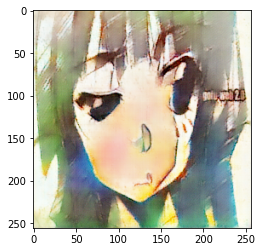

  3%|▎         | 25/756 [00:53<26:38,  2.19s/it]


MEDIUM LOSS GENERATOR FOR THIS EPOCH:  18.69057289123535


  6%|▋         | 49/756 [01:43<24:52,  2.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/0]  it:50	Loss_D: 0.7803	Loss_G: 19.9051	D(x): 0.8032	D(G(z)): 0.2013 / 0.1218
0.38699355721473694
l2 loss last it 0.15599392354488373
bce loss last it 4.516284942626953


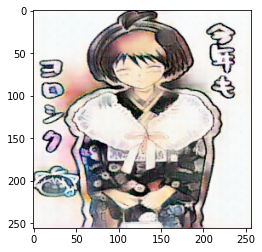

  7%|▋         | 50/756 [01:46<25:45,  2.19s/it]


MEDIUM LOSS GENERATOR FOR THIS EPOCH:  19.297824649810792


 10%|▉         | 74/756 [02:36<23:56,  2.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/0]  it:75	Loss_D: 0.3767	Loss_G: 20.9977	D(x): 0.8880	D(G(z)): 0.1069 / 0.0442
0.6743348836898804
l2 loss last it 0.17922824621200562
bce loss last it 2.93628191947937


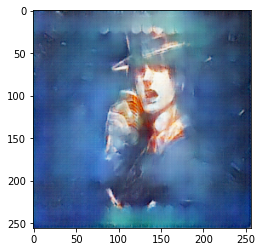

 10%|▉         | 75/756 [02:38<24:58,  2.20s/it]


MEDIUM LOSS GENERATOR FOR THIS EPOCH:  19.864443168640136


 13%|█▎        | 99/756 [03:29<23:04,  2.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/0]  it:100	Loss_D: 1.1155	Loss_G: 21.0402	D(x): 0.8001	D(G(z)): 0.2309 / 0.0975
0.577819287776947
l2 loss last it 0.16515910625457764
bce loss last it 4.575173377990723


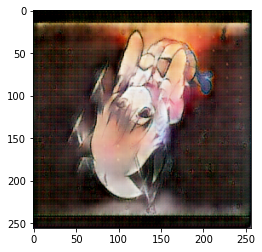

 13%|█▎        | 100/756 [03:31<24:04,  2.20s/it]


MEDIUM LOSS GENERATOR FOR THIS EPOCH:  20.158379583358766


 16%|█▋        | 124/756 [04:22<22:16,  2.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/0]  it:125	Loss_D: 1.1516	Loss_G: 18.5507	D(x): 0.7009	D(G(z)): 0.2690 / 0.2130
0.6443859934806824
l2 loss last it 0.17482870817184448
bce loss last it 1.6230835914611816


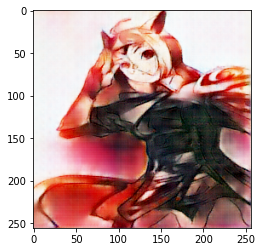

 17%|█▋        | 125/756 [04:25<23:16,  2.21s/it]


MEDIUM LOSS GENERATOR FOR THIS EPOCH:  19.836845031738285


 20%|█▉        | 149/756 [05:15<21:18,  2.11s/it]

In [ ]:
G_losses = []
D_losses = []
img_list = []
mean_loss_G = 0
mean_loss_D = 0
D_D_x = 0
D_G_x = 0
D_G_x2 = 0
frequncy_update = 25
for ep in range(0, epochs):
  i = 0
  G_losses = []
  for outlines,targets in tqdm(train_dataloader):    

    
    outlines = outlines.to(device)
    targets = targets.to(device)
    ###################################
    #training of discriminator
    ###################################
    Disc.zero_grad()

    #train with real images
    output = Disc(targets)    
    #print("discriminator of real images", output)
    #view is used because output contains value returned and gradient, the target is 1 since those are real images
    loss_D_real = criterionBC(output.view(-1), torch.ones_like(output.view(-1)) )
    loss_D_real.backward()
    #colecting informations
    output  = torch.sigmoid(output)
    D_G_x += output.mean().item()

    
    generated =  first_T(outlines) 
    

    output_gen = Disc(generated.detach())
    #print("discriminator of fake images", output_gen)
    loss_D_fake = criterionBC(output_gen.view(-1), torch.zeros_like(output_gen.view(-1)) )
    loss_D_fake.backward()
    #colecting informations
    output_gen  = torch.sigmoid(output_gen)
    D_G_x2 += output_gen.mean().item()
    loss_D = loss_D_real + loss_D_fake
    mean_loss_D += loss_D.item()
    
    #plot_grad_flow(Disc.named_parameters())
    if D_G_x2 > 0 :
      optimizerD.step()  #update discriminator weigths
    
    ###################################
    #training generator
    #the main part is the sketch network: second_T
    #it needs the outlines and a color scheme
    #the color scheme can be obtained with first_T or with blured target images
    ###################################
    
    first_T.zero_grad() 

    #discriminate our generated images with updated discriminator
    output_gen_new = Disc(generated)
    #the target labels are the one for real image, this is import and simplifies the training of the generator
    loss_gen_new = criterionBC(output_gen_new.view(-1), torch.ones_like(output_gen_new.view(-1)) )
    
    #attempt of using l2 loss
    #l2_loss_color = criterionL2( color_scheme,  targets)
    l2_loss = criterionL2(generated, targets)
    loss_G =  loss_gen_new + l2_loss *100#+ l2_loss_color
    mean_loss_G += loss_G.item()  
      
    loss_G.backward()

    #loss_gen_new.backward()
    output_gen_new = torch.sigmoid(output_gen_new)
    D_D_x += output_gen_new.mean().item()
    #optimizerT2.step()
    optimizerT1.step()


    i += 1
    if i % frequncy_update == 0:
      mean_loss_G, mean_loss_D = mean_loss_G / frequncy_update, mean_loss_D / frequncy_update
      D_G_x, D_G_x2, D_D_x = D_G_x/frequncy_update, D_G_x2/frequncy_update, D_D_x/frequncy_update
      print('[%d/%d]  it:%d\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epochs, ep, i, mean_loss_D, mean_loss_G, D_G_x, D_G_x2, D_D_x))
      print_avg_grad(first_T.named_parameters())    
      #print_avg_grad(second_T.named_parameters())
      print("l2 loss last it", l2_loss.item())
      print("bce loss last it", loss_gen_new.item())
      im_g  = generated[0].to("cpu").detach().permute(1,2,0).numpy() 
      plt.imshow(im_g)
      #display.clear_output(wait=True)
      display.display(plt.gcf())
      #time.sleep(0.1)
      G_losses.append(mean_loss_G)
      print("")
      print("MEDIUM LOSS GENERATOR FOR THIS EPOCH: ",sum(G_losses)/len(G_losses))
      
      """
      with open(path_main_folder+"report.txt", "a") as file_object:
        file_object.write( '\n[%d/%d] it:%d\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epochs, ep, i, mean_loss_D, mean_loss_G, D_G_x, D_G_x2, D_D_x) ) 
      #reset all loss and output collected  """
      mean_loss_G, mean_loss_D, D_G_x, D_G_x2, D_D_x = 0, 0, 0, 0, 0


    

    #break
  #break
  PATH = path_main_folder + "models/D_U_good.pth"
  torch.save(Disc.state_dict(), PATH)
  PATH2 = path_main_folder + "models/T1_U_good.pth"
  torch.save(first_T.state_dict(), PATH2)


In [ ]:
#ep loss    21.02
#ep loss    20.339275258382163
#ep loss    20.040012555652194
#ep ++ loss 19.155535490101784